# EDA of News Articles IR System

Initial exploration of the dataset to understand dataset structure, category distribution, tokenization & preprocessing effects, and sample TF–IDF & BM25 scoring.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

filePath = Path("../data/Articles.csv")

In [28]:
df = pd.read_csv(filePath)
df.head()

# corrected code is in the next cell, used GPT to resolve the error

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb4 in position 1644: invalid start byte

In [29]:
def safe_read_csv(path):
    """Try multiple encodings until one works."""
    encodings_to_try = ["utf-8", "latin1", "windows-1252"]

    for enc in encodings_to_try:
        try:
            return pd.read_csv(path, encoding=enc)
        except UnicodeDecodeError:
            print(f"Encoding failed: {enc}")

    # Last fallback: ignore errors (loads file even if some characters are bad)
    return pd.read_csv(path, encoding="utf-8", errors="ignore")

df = safe_read_csv(filePath)

Encoding failed: utf-8


In [30]:
# Loading data handling UTF-8, Latin-1, Windows-1252 encodings)

def safe_read_csv(path):
    """Try multiple encodings until one works."""
    encodings_to_try = ["utf-8", "latin1", "windows-1252"]

    for enc in encodings_to_try:
        try:
            print(f"Trying encoding: {enc}")
            return pd.read_csv(path, encoding=enc)
        except UnicodeDecodeError:
            print(f"Encoding failed: {enc}")

    raise UnicodeDecodeError("All encodings failed.")

df = safe_read_csv(filePath)

Trying encoding: utf-8
Encoding failed: utf-8
Trying encoding: latin1


In [31]:
df.head()

,Article,Date,Heading,NewsType
0,KARACHI: The Sindh government has decided to b...,1/1/2015,sindh govt decides to cut public transport far...,business
1,HONG KONG: Asian markets started 2015 on an up...,1/2/2015,asia stocks up in new year trad,business
2,HONG KONG: Hong Kong shares opened 0.66 perce...,1/5/2015,hong kong stocks open 0.66 percent lower,business
3,HONG KONG: Asian markets tumbled Tuesday follo...,1/6/2015,asian stocks sink euro near nine year,business
4,NEW YORK: US oil prices Monday slipped below $...,1/6/2015,us oil prices slip below 50 a barr,business


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2692 entries, 0 to 2691
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Article   2692 non-null   object
 1   Date      2692 non-null   object
 2   Heading   2692 non-null   object
 3   NewsType  2692 non-null   object
dtypes: object(4)
memory usage: 84.3+ KB


In [33]:
df.describe(include='all')

,Article,Date,Heading,NewsType
count,2692,2692,2692,2692
unique,2584,666,2581,2
top,strong>TOKYO: Tokyo stocks climbed in early tr...,8/1/2016,IMF release final instalment 66 bn loan Paki,sports
freq,5,27,5,1408


# Category Distribution (`NewsType`)

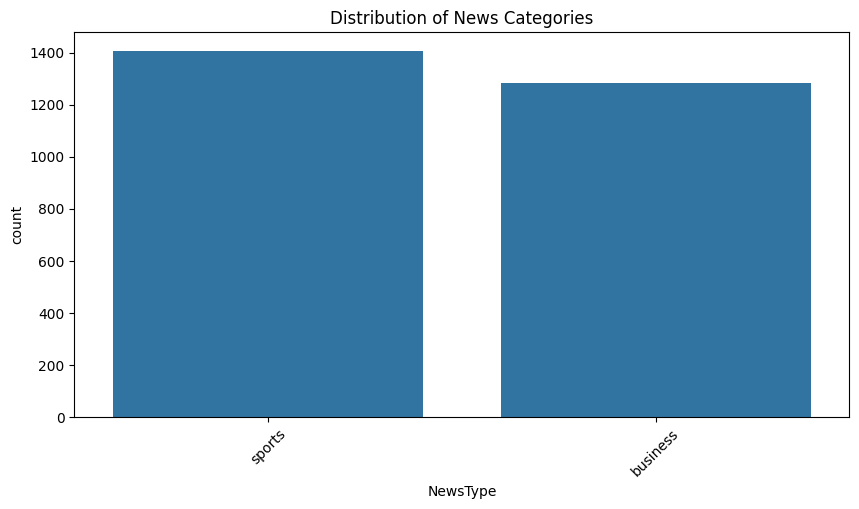

In [34]:
plt.figure(figsize=(10,5))
sns.countplot(x=df['NewsType'], order=df['NewsType'].value_counts().index)
plt.title("Distribution of News Categories")
plt.xticks(rotation=45)
plt.show()

# Article Length Analysis

In [35]:
df['length'] = df['Article'].str.len()
df['length'].describe()

count     2692.000000
mean      1810.019688
std       1080.292897
min        216.000000
25%       1032.750000
50%       1647.500000
75%       2325.250000
max      19199.000000
Name: length, dtype: float64

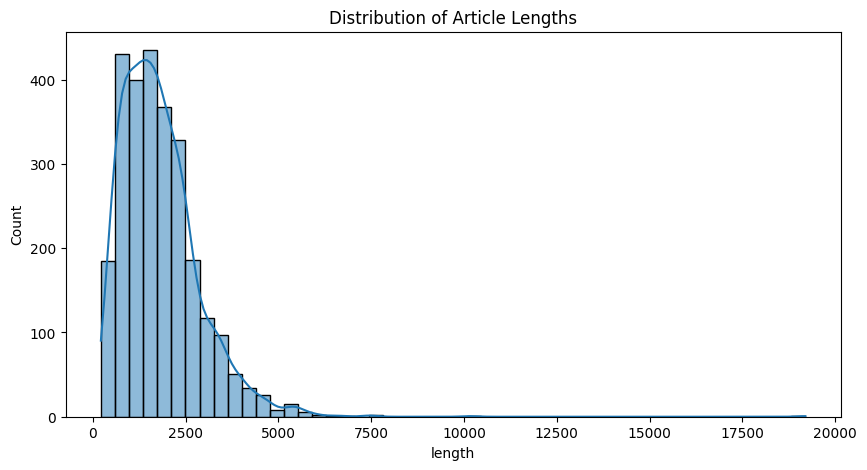

In [36]:
plt.figure(figsize=(10,5))
sns.histplot(df['length'], bins=50, kde=True)
plt.title("Distribution of Article Lengths")
plt.show()

# Preprocessing Experiments

Testing preprocessing functions before using them in the IR pipeline

In [37]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')

STOPWORDS = set(stopwords.words('english'))
STEM = PorterStemmer()

def normalize(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

sample = df['Article'].iloc[0]
sample_norm = normalize(sample)
sample_tokens = [w for w in sample_norm.split() if w not in STOPWORDS]
sample_stems = [STEM.stem(w) for w in sample_tokens]

sample, sample_norm, sample_tokens[:20], sample_stems[:20]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sana.ilyas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


('KARACHI: The Sindh government has decided to bring down public transport fares by 7 per cent due to massive reduction in petroleum product prices by the federal government, Geo News reported.Sources said reduction in fares will be applicable on public transport, rickshaw, taxi and other means of traveling.Meanwhile, Karachi Transport Ittehad (KTI) has refused to abide by the government decision.KTI President Irshad Bukhari said the commuters are charged the lowest fares in Karachi as compare to other parts of the country, adding that 80pc vehicles run on Compressed Natural Gas (CNG). Bukhari said Karachi transporters will cut fares when decrease in CNG prices will be made.                        \r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n',
 'karachi the sindh government has decided to bring down public transport fares by per cent due to massive reduction in petroleum product prices by the federal government geo news reported sources said reduction in fares will be applicable on pub

# TF–IDF overview

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

subset = df['Article'][:100].fillna("")
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(subset)

query = "oil prices rise"
q_vec = vectorizer.transform([query])

scores = (q_vec @ X.T).toarray()[0]
top = np.argsort(scores)[::-1][:5]
top

array([14,  4, 50, 59, 64], dtype=int64)

# BM25 overview

In [39]:
from rank_bm25 import BM25Okapi

tokenized_subset = [normalize(doc).split() for doc in subset]
bm25 = BM25Okapi(tokenized_subset)

query_tokens = normalize(query).split()
scores = bm25.get_scores(query_tokens)

np.argsort(scores)[::-1][:5]

array([50, 14, 10,  4, 85], dtype=int64)

By performing the above steps, I've checked loading the dataset and have an overview of it. Moreover, it helped me test preprocessing steps. I also performed TF–IDF and BM25 experiments to check if they would work in full IR system.